<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/Kaggle_Disaster_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git
!pip install transformers
!pip install scikit-optimize

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *

import torch
import torch.optim as optim

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import AlbertForSequenceClassification, AlbertTokenizer, AlbertConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
show_install()




```text
=== Software === 
python        : 3.6.9
fastai        : 1.0.61.dev0
fastprogress  : 0.2.2
torch         : 1.3.1
nvidia driver : 418.67
torch cuda    : 10.1.243 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-ru

In [4]:


import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)



fastai version : 1.0.61.dev0
transformers version : 2.3.0


# Exploratory Data Analysis

In [5]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [0]:
df = pd.read_csv('train.csv')


In [7]:
print(len(df))

df.head(5)

7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


[1 0]


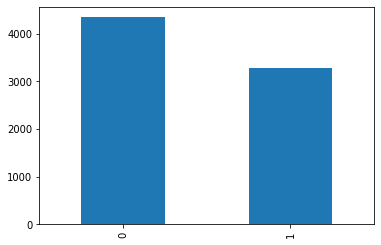

In [8]:
df['target'].value_counts().plot(kind='bar')

print(df['target'].unique())

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['target'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [10]:
train_idx, val_idx = next(sss.split(df['text'], df['target']))

print(len(train_idx), len(val_idx))

6090 1523


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

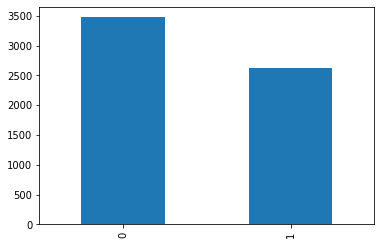

In [13]:
df_train['target'].value_counts().plot(kind='bar')

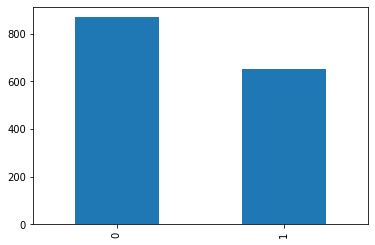

In [14]:
df_val['target'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Setting up data for transformers

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}


In [0]:
# Parameters
# seed = 42
use_fp16 = False
model_type = 'roberta'
pretrained_model_name = 'roberta-base' # 'roberta-base-openai-detector'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [20]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]
model_class.pretrained_model_archive_map.keys()

dict_keys(['roberta-base', 'roberta-large', 'roberta-large-mnli', 'distilroberta-base', 'roberta-base-openai-detector', 'roberta-large-openai-detector'])

## Setting up tokenizer + numericalizer


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [23]:
tokenizer_class.pretrained_vocab_files_map

{'merges_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-merges.txt',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt',
  'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-merges.txt',
  'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt'},
 'vocab_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-vocab.json',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'robert

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

## Setting up databunch


In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [37]:
bs = 32

data_clas = (TextList.from_df(df, cols='text', processor=transformer_processor)
             .split_by_idxs(train_idx, val_idx)
             .label_from_df(cols= 'target')
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))



In [38]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
data_clas.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


text,target
<s> Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : Ġ. : ĠRT ĠDr A yes ha 4 : Ġ# India Ko M un Tor J aw ab Do Ċ Ċ Indian ĠArmy Ġki Â ī ÃĽ _ Ġhttp,0
<s> Ġ( OFF IC IAL ĠVID ) Ġ& gt ; Ġ# Double C ups Ġ& gt ; & gt ; Ġhttps :// t . co / lf K MT Z a E kk Ġ& gt ; & gt ; Ġ@ Tr ub G ME ĠPro d Ġ@ THIS IZ B WR IGHT Ġ& gt ; & gt ; Ġ# ARM AG ED DON Ġ Ġ Ġ Ġ Ġ Ġ Ġ,0
<s> ĠSE VER E ĠWE ATHER ĠB UL LET IN ĠNo . Ġ5 ĠFOR : ĠTY PH O ON ĠÂ ī ÃĽ Ã ı # H anna PH Â ī ÃĽ Â Ŀ Ġ( S OU D EL OR ) ĠTR OP ICAL ĠCY CL ONE : ĠWARNING ĠIS SU ED ĠAT Ġ5 : 00 ĠPM Ġ06 ... Ġhttp :// t . co / t H h j J w,1
<s> Ġ320 Ġ[ IR ] ĠIC EM O ON Ġ[ AF T ERS H OCK ] Ġ| Ġhttp :// t . co / y N X nv V KC DA Ġ| Ġ@ dj ic em oon Ġ| Ġ# Dub step Ġ# T rap Music Ġ# D n B Ġ# ED M Ġ# D ance Ġ# I ces Â ī ÃĽ _ Ġhttp :// t . co / we Q P,0
<s> Ġi em bot _ h fo Ġ: ĠAt Ġ10 : 00 ĠAM Ġ2 ĠN NW ĠH ana Ġ[ M au i ĠCo ĠHI ] ĠCOUNTY ĠOFFIC IAL Ġreports ĠCO AST AL ĠFL OOD Ġ# Â ī ÃĽ _ Ġhttp :// t . co / G g 0 d Z S v B Z 7 ) Ġhttp :// t . co / k Be 91 a RC d w </s>,1


In [39]:
# checking batch and numericalizer

print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = data_clas.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)



[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([32, 86])
tensor([[    0,   479,    35,  ...,   306,   571,     2],
        [    0,   289, 22323,  ...,     1,     1,     1],
        [    0,   939,   991,  ...,     1,     1,     1],
        ...,
        [    0,    20,   211,  ...,     1,     1,     1],
        [    0, 18762,  7469,  ...,     1,     1,     1],
        [    0,    83, 44037,  ...,     1,     1,     1]])


# RoBERTa

In [0]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [41]:
n_labels = 2

config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = n_labels
config.use_bfloat16 = use_fp16
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}



In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Creating learner

In [0]:
from transformers import AdamW
from ranger import Ranger

In [0]:
optar = partial(Ranger)

In [89]:
try: 
    learn.destroy()
except:
    'no learner created'

learn = Learner(data_clas,
               custom_transformer_model,
            #    opt_func = lambda input: AdamW(input,correct_bias=False, eps = 1e-4),
               opt_func = optar,
               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
               metrics = [accuracy])

this Learner object self-destroyed - it still exists, but no longer usable


### Creating layer splitting for gradual unfreezing and discriminative learning rates

use   "num_hidden_layers" in config + 2 (1 for embedding and 1 for head)

In [0]:
# For roberta-base
list_layers = [learn.model.transformer.roberta.embeddings,
              learn.model.transformer.roberta.encoder.layer[0],
              learn.model.transformer.roberta.encoder.layer[1],
              learn.model.transformer.roberta.encoder.layer[2],
              learn.model.transformer.roberta.encoder.layer[3],
              learn.model.transformer.roberta.encoder.layer[4],
              learn.model.transformer.roberta.encoder.layer[5],
              learn.model.transformer.roberta.encoder.layer[6],
              learn.model.transformer.roberta.encoder.layer[7],
              learn.model.transformer.roberta.encoder.layer[8],
              learn.model.transformer.roberta.encoder.layer[9],
              learn.model.transformer.roberta.encoder.layer[10],
              learn.model.transformer.roberta.encoder.layer[11],
              learn.model.transformer.roberta.pooler]

In [91]:
# check groups
learn.split(list_layers)
num_groups = len(learn.layer_groups)
print('Learner split in',num_groups,'groups')
# print(learn.layer_groups)



Learner split in 14 groups


Optional: Freeze the model to train the head

In [92]:
# learn.freeze();

learn.unfreeze();
learn.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [86, 768]            38,603,520 True      
______________________________________________________________________
Embedding            [86, 768]            394,752    True      
______________________________________________________________________
Embedding            [86, 768]            768        True      
______________________________________________________________________
LayerNorm            [86, 768]            1,536      True      
______________________________________________________________________
Dropout              [86, 768]            0          False     
______________________________________________________________________
Linear               [86, 768]            590,592    True      
______________________________________________________________________
Linear               [86, 768]            590,592    True      
_______________________________________

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

In [0]:
learn.to_fp16()

lr_init = 3e-5
lr = lr_init

"""Training without adjusting the momentum"""
# learn.fit_one_cycle(10, 
#                     lr, 
#                     pct_start = 0.3,
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])

"""Training discriminative learning rates"""
# learn.fit_one_cycle(5, 
#                     slice(lr/10, lr), 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])
"""
Clipping momentum
"""


# learn.fit_one_cycle(10, 
#                     lr, 
#                     moms=(0.8,0.7),
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])

"""Training Ranger"""
learn.fit_fc(10, 
            lr, 
            callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                        name='classifier_stage1')])



"""

Warmup cosine with restarts

"""

def fit_cosine_restart(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len

    learn.fit(total_epochs, 
              callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                 name='classifier_stage1')])

# fit_cosine_restart(learn, 15, lr, 0.9, 1, 2)


learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.688223,0.686504,0.570584,00:30


Better model found at epoch 0 with accuracy value: 0.5705843567848206.


**Results**

approx 85.3% accuracy training unfrozen model (without discriminative learning rate) for 5 epochs


In [0]:
try: 
    learn.load('classifier_stage1')
except:
    print('no learner created')
learn.unfreeze();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.45E-06


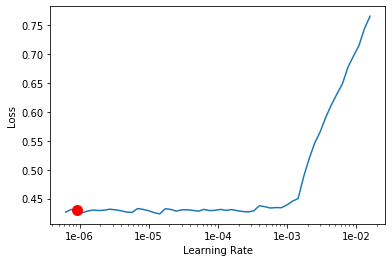

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion = True, skip_end=15)

epoch,train_loss,valid_loss,accuracy,time
0,0.434869,0.721140,0.849787,01:30
1,0.434051,0.717225,0.853522,01:28
2,0.436040,0.719871,0.852455,01:28
3,0.432516,0.726608,0.850053,01:29
4,0.422930,0.723581,0.852721,01:25
5,0.428491,0.722514,0.851921,01:30
6,0.432937,0.718698,0.851921,01:27
7,0.417993,0.723793,0.856190,01:26
8,0.417185,0.731162,0.851387,01:27
9,0.414973,0.727615,0.851654,01:26


Better model found at epoch 0 with accuracy value: 0.8497865796089172.
Better model found at epoch 1 with accuracy value: 0.8535218834877014.
Better model found at epoch 7 with accuracy value: 0.8561899662017822.


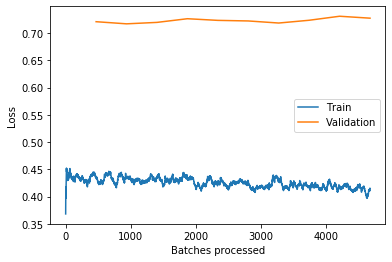

In [0]:
lr = 3e-5
"""Training without adjusting the momentum"""
# learn.fit_one_cycle(10, 
#                     slice(lr/100,lr/10),
#                     pct_start = 0.3, 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage2')])

# """Training discriminative learning rates"""
# learn.fit_one_cycle(5, 
#                     slice(lr/10, lr), 
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])
"""
Clipping momentum
"""


# learn.fit_one_cycle(10, 
#                     lr, 
#                     moms=(0.8,0.7),
#                     callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                  name='classifier_stage1')])


"""
Training Ranger

"""
learn.fit_fc(10, 
            lr/10, 
            callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                        name='classifier_stage1')])


"""
cosine anneal with restarts
"""
# fit_cosine_restart(learn, 5, lr, 0.9, 1, 2)


learn.recorder.plot_losses()

### Getting validation F1

In [0]:
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score



In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data_clas.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [81]:
val_preds = get_preds_as_nparray(DatasetType.Valid)

In [0]:
vpreds = []
for i in val_preds:
    vpreds.append(np.argmax(i))



In [83]:
print(classification_report(df_val['target'], vpreds))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73       869
           1       0.00      0.00      0.00       654

    accuracy                           0.57      1523
   macro avg       0.29      0.50      0.36      1523
weighted avg       0.33      0.57      0.41      1523



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Generating Predictions for submission

In [0]:
df_test = pd.read_csv('test.csv')

In [86]:
learn.data.add_test(df_test)
test_preds = get_preds_as_nparray(DatasetType.Test)
preds = []
for i in test_preds:
    preds.append(np.argmax(i))

In [87]:
sub = pd.read_csv("sample_submission.csv")
sub['target'] = preds
sub.to_csv('submission.csv', index=False)
sub.head(3)

,id,target
0,0,0
1,2,0
2,3,0


# Hyperparam tuning

In [0]:

from hyperband import hyperband
from skopt.space import Integer, Real, Categorical
space = [
         Real(0.05, 0.9, name = 'pct_start'),
         Real(0.8, 0.9, name = 'b1'),
         Real(0.7, 0.999, name = 'b2')
]

# add hyperparams from space here
def fit_and_score(resources, checkpoint, pct_start, b1, b2):
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    learn = Learner(data_clas,
            custom_transformer_model,
            opt_func = lambda input: AdamW(input,correct_bias=False),
            loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
            metrics = [accuracy])
    
    learn.to_fp16()

    lr = 3e-5
    learn.fit_one_cycle(1, 
                lr,
                pct_start = pct_start,
                moms = (b1, b2),
                callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                                                name='classifier_stage1')])

    val_accuracy = learn.validate(learn.data.valid_dl)[1].numpy()

    # Maximisation problem
    return - val_accuracy, [pct_start, b1, b2]


accuracies, hps = hyperband(objective=fit_and_score, dimensions=space)
for acc, hp in zip(accuracies, hps):
    print(acc, hp)
